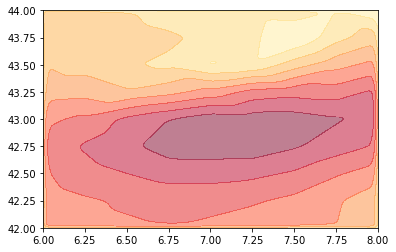

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
import mplleaflet
import numpy as np
import branca
from folium import plugins
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage

df=pd.read_csv('data_tibaut.csv')
df["Vitesse"] = round((df["u"]**2 + df["v"]**2)**0.5,1)

x = df["lon"]
y = df["lat"]
U = df["u"]
V = df["v"]
fig, ax = plt.subplots()

kw = dict(color='black', alpha=0.8, scale=50)
q = ax.quiver(x, y, U, V, **kw)

gj = mplleaflet.fig_to_geojson(fig=fig)


feature_group0 = folium.FeatureGroup(name='Vecteurs')
#feature_group1 = folium.FeatureGroup(name='coucou')  


mapa = folium.Map(location=[y.mean(), x.mean()], tiles="Cartodb Positron",
                  zoom_start=7)

for feature in gj['features']:
    if feature['geometry']['type'] == 'Point':
        lon, lat = feature['geometry']['coordinates']
        div = feature['properties']['html']

        icon_anchor = (feature['properties']['anchor_x'],
                       feature['properties']['anchor_y'])

        icon = folium.features.DivIcon(html=div,
                                       icon_anchor=icon_anchor)
        marker = folium.Marker([lat, lon], icon=icon)
        feature_group0.add_child(marker)
    else:
        msg = "Unexpected geometry {}".format
        raise ValueError(msg(feature['geometry']))
        
mapa.add_child(feature_group0)
#mapa.add_children(feature_group1)


for i in range(df.shape[0]):
    latitude = df.iloc[i,2]
    longitude = df.iloc[i,1]
    vitesse = df.iloc[i,5]
    m = "<strong>" + "Vitesse : " + "</strong>" + str(vitesse) + " m/s"
    folium.CircleMarker([latitude, longitude], radius = 5,color=None,fill_color ="red",
                    fill_opacity=0.5,popup = folium.Popup(m, max_width = 400)).add_to(mapa)

    



# Setup colormap
colors = ["#ffeda0" ,"#fed976", "#feb24c", "#fd8d3c", "#fc4e2a", "#e31a1c", "#bd0026", "#800026"]
vmin   = 0 
vmax   = 7 
levels = len(colors)
feature_group1 = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)
 
# The original data
x_orig = np.asarray(df.lon.tolist())
y_orig = np.asarray(df.lat.tolist())
z_orig = np.asarray(df.Vitesse.tolist())
 
# Make a grid
x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 500)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 500)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
 
# Grid the values
z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')
 
# Gaussian filter the grid to make it smoother
sigma = [5, 5]
z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')
 
# Create the contour
contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors, linestyles='None', vmin=vmin, vmax=vmax)
 
# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.9);
 
# Plot the contour plot on folium
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   1,
    }, name="Couleurs d'interpolation").add_to(mapa)
 
# Add the colormap to the folium map
feature_group1.caption = 'Temperature'
 

mapa.add_child(feature_group1)
mapa.add_child(folium.map.LayerControl())

mapa